In [1]:
%pylab inline
from utils import *
from data import *
from scoring import *

Populating the interactive namespace from numpy and matplotlib


# Longliners

Fitting an optimal window size for avg/stddev columns
1800: Fitting... Scoring... Calc.err... train=0.20880030434, cross=0.213230236883
3600: Fitting... Scoring... Calc.err... train=0.204116378067, cross=0.207028109338
10800: Fitting... Scoring... Calc.err... train=0.189918531318, cross=0.189815423267
21600: Fitting... Scoring... Calc.err... train=0.178021431264, cross=0.17838686361
43200: Fitting... Scoring... Calc.err... train=0.15165218836, cross=0.151309667029
86400: Fitting... Scoring... Calc.err... train=0.16235084137, cross=0.16270234327


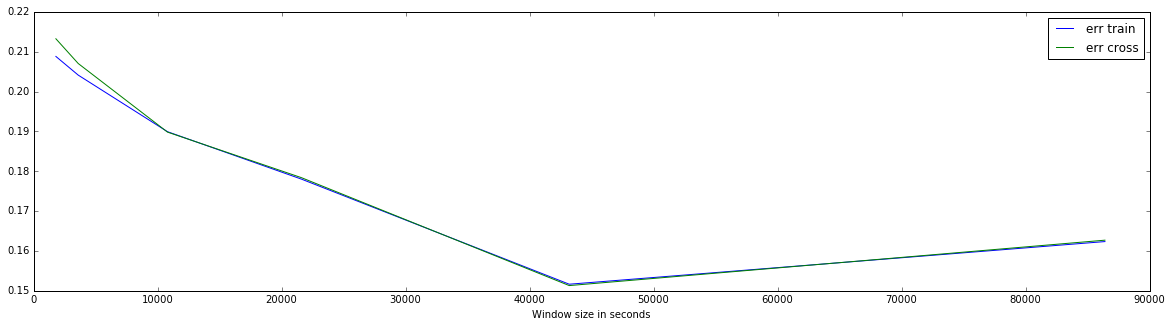

Best window size: 43200
Fitting an optimal degree of polynomial
2: Fitting... Scoring... Calc.err... train=0.168048348401, cross=0.168468691406
3: Fitting... Scoring... Calc.err... train=0.15639503369, cross=0.15626038595
4: Fitting... Scoring... Calc.err... train=0.15165218836, cross=0.151309667029
5: Fitting... Scoring... Calc.err... train=0.150229170052, cross=0.149580704952
6: Fitting... Scoring... Calc.err... train=0.150270077282, cross=0.149318749455
7: Fitting... Scoring... Calc.err... train=0.151594808165, cross=0.151196796582
8: Fitting... Scoring... Calc.err... train=0.152780651784, cross=0.152353557359
9: Fitting... Scoring... Calc.err... train=0.155053225285, cross=0.154730865105


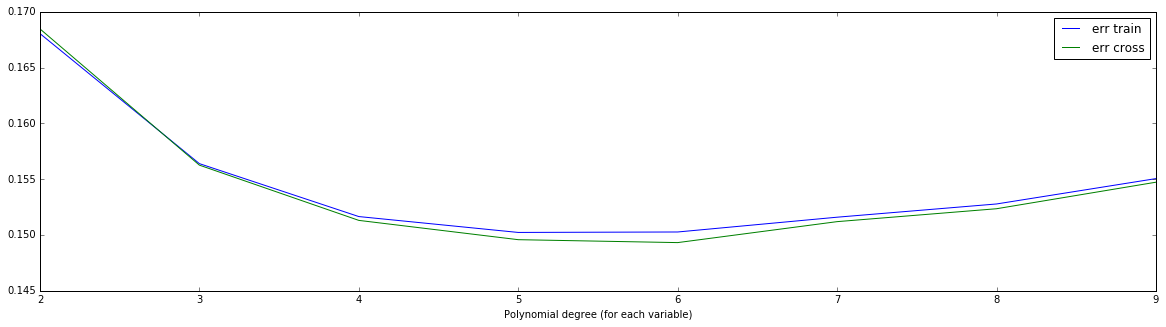

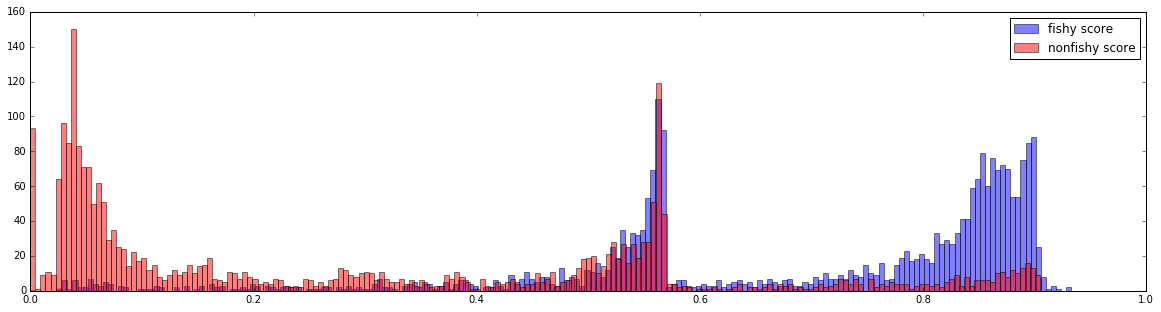

Squared numerical error: 0.146600976986
Error (overlap): 31.16%
False positives given cutoff at 0.5: 34.701986755%


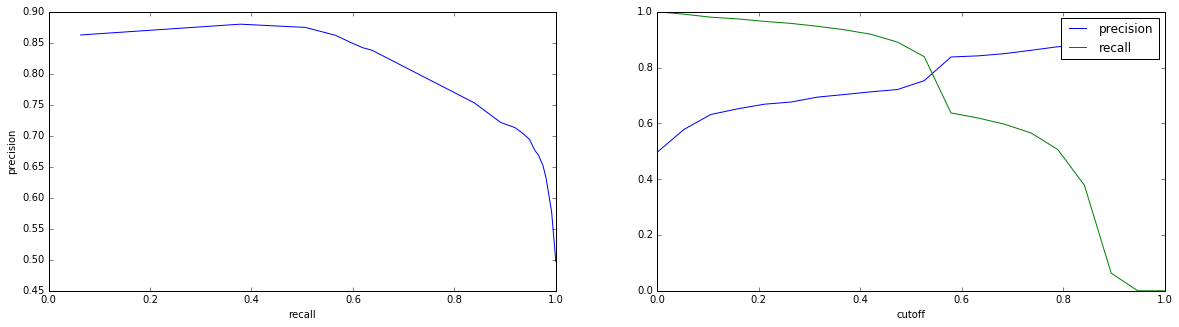

Score window: 43200
Score polynomial: [ -5.0130533    0.15170365  14.80828424 -14.44828474 -22.29838855
  -5.0130533  -57.41256606 -67.21236372 -30.14567892  -4.52592998
  -5.0130533    3.35178971  -2.84941593  -3.88905678  -0.89660454]


In [2]:
xtrain, xcross, xtest = load_dataset('datasets/kristina_longliner.measures.npz')
min_window = optimize_window_size(xtrain, xcross)
optimize_polynomial_degree(xtrain, xcross, min_window)
evaluate_score(xtrain, xtest, 5, min_window)

# Trawlers

Fitting an optimal window size for avg/stddev columns
1800: Fitting... Scoring... Calc.err... train=0.137653754022, cross=0.133721250957
3600: Fitting... Scoring... Calc.err... train=0.135574062462, cross=0.131242345665
10800: Fitting... Scoring... Calc.err... train=0.133800176253, cross=0.132923931174
21600: Fitting... Scoring... Calc.err... train=0.140086888881, cross=0.137971525359
43200: Fitting... Scoring... Calc.err... train=0.151444321658, cross=0.149870002942
86400: Fitting... Scoring... Calc.err... train=0.17068540589, cross=0.169230264722


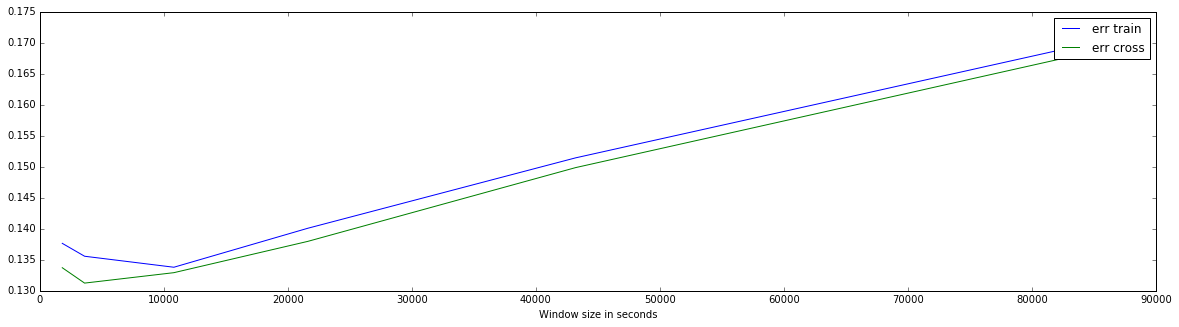

Best window size: 3600
Fitting an optimal degree of polynomial
2: Fitting... Scoring... Calc.err... train=0.214207958169, cross=0.211104152972
3: Fitting... Scoring... Calc.err... train=0.147693781856, cross=0.143451923512
4: Fitting... Scoring... Calc.err... train=0.135574062462, cross=0.131242345665
5: Fitting... Scoring... Calc.err... train=0.130391624367, cross=0.126196549383
6: Fitting... Scoring... Calc.err... train=0.129717196412, cross=0.125859371497
7: Fitting... Scoring... Calc.err... train=0.493851818929, cross=0.491632773298
8: Fitting... Scoring... Calc.err... train=0.469384067282, cross=0.46383416968
9: Fitting... Scoring... Calc.err... train=0.499792892551, cross=0.501829808946


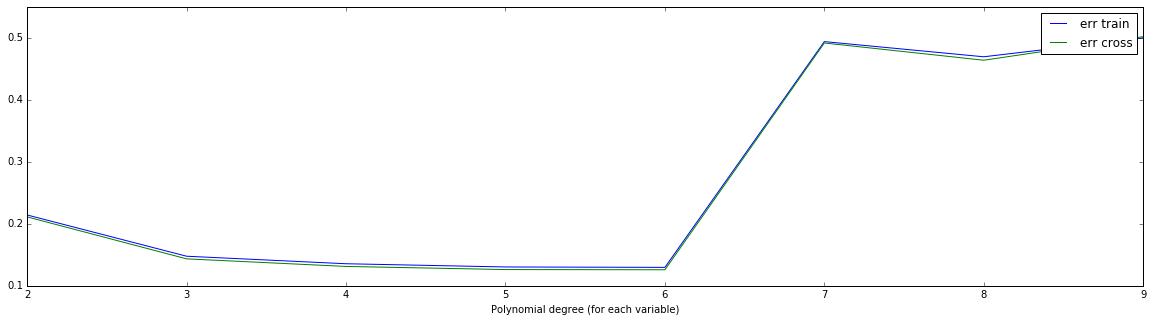

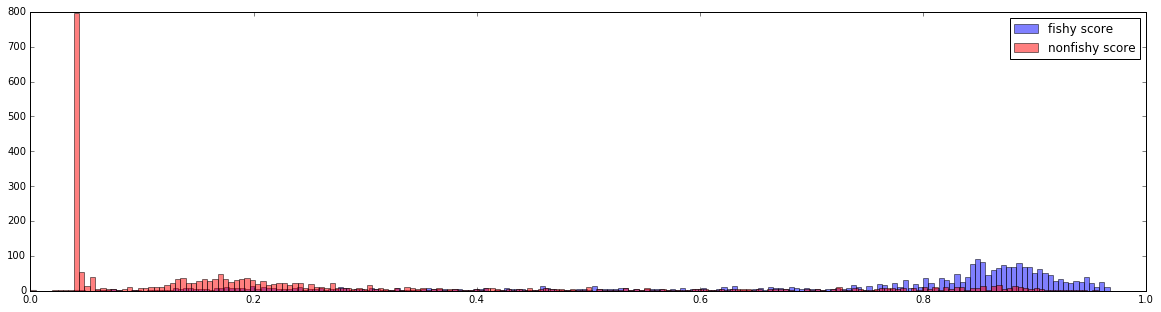

Squared numerical error: 0.128516814652
Error (overlap): 33.12%
False positives given cutoff at 0.5: 34.6487766377%


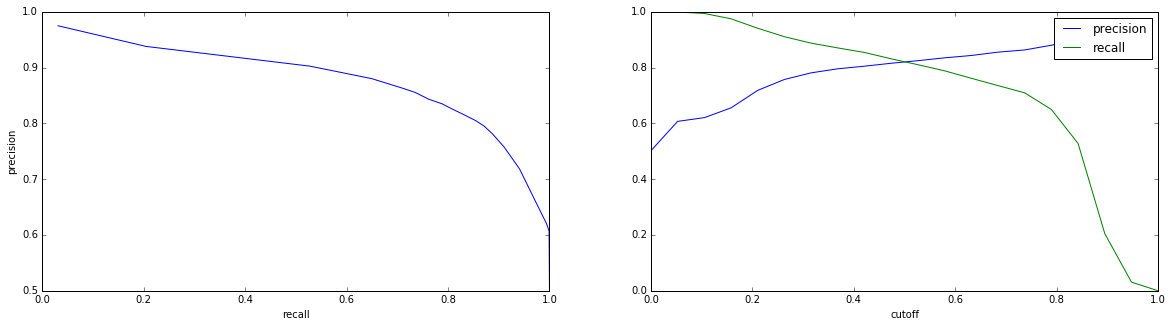

Score window: 3600
Score polynomial: [  -5.34867826   54.38363367 -199.18254235  313.35837926 -164.37174392
   -5.34867824  -16.93588143  -16.04153844   -6.1824464    -0.82970585
   -5.34867824  -12.53846471  -13.05006605   -5.21258221   -0.72094983]


In [3]:
xtrain, xcross, xtest = load_dataset('datasets/kristina_trawl.measures.npz')
min_window = optimize_window_size(xtrain, xcross)
optimize_polynomial_degree(xtrain, xcross, min_window)
evaluate_score(xtrain, xtest, 5, min_window)

# Purse seiners

Fitting an optimal window size for avg/stddev columns
1800: Fitting... Scoring... Calc.err... train=0.131587885284, cross=0.126330434707
3600: Fitting... Scoring... Calc.err... train=0.135314126891, cross=0.130980646403
10800: Fitting... Scoring... Calc.err... train=0.131451752223, cross=0.131063399175
21600: Fitting... Scoring... Calc.err... train=0.136842745629, cross=0.136634862691
43200: Fitting... Scoring... Calc.err... train=0.14040682266, cross=0.138359994371
86400: Fitting... Scoring... Calc.err... train=0.129131171104, cross=0.123547918662


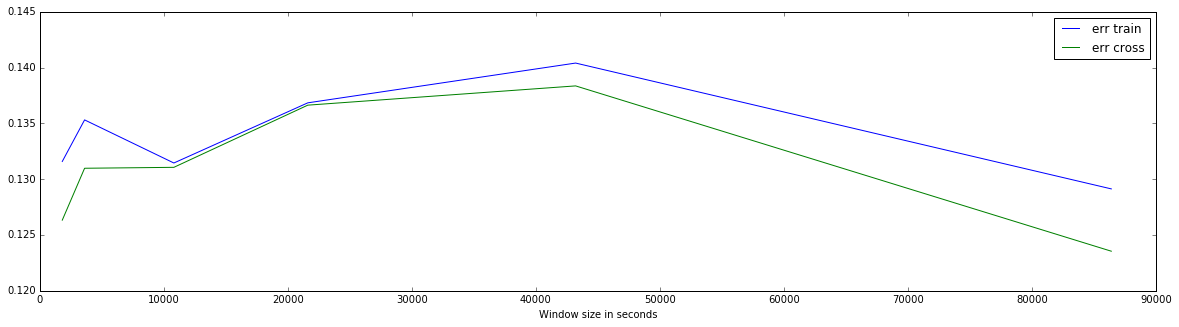

Best window size: 86400
Fitting an optimal degree of polynomial
2: Fitting... Scoring... Calc.err... train=0.159593870438, cross=0.156581997306
3: Fitting... Scoring... Calc.err... train=0.14446497523, cross=0.141478777707
4: Fitting... Scoring... Calc.err... train=0.129131171104, cross=0.123547918662
5: Fitting... Scoring... Calc.err... train=0.128304812352, cross=0.122503950589
6: Fitting... Scoring... Calc.err... train=0.140839623043, cross=0.137696060857
7: Fitting... Scoring... Calc.err... train=0.2343909246, cross=0.235287000155
8: Fitting... Scoring... Calc.err... train=0.12824427991, cross=0.122284108296
9: Fitting... Scoring... Calc.err... train=0.12773187074, cross=0.121485223638


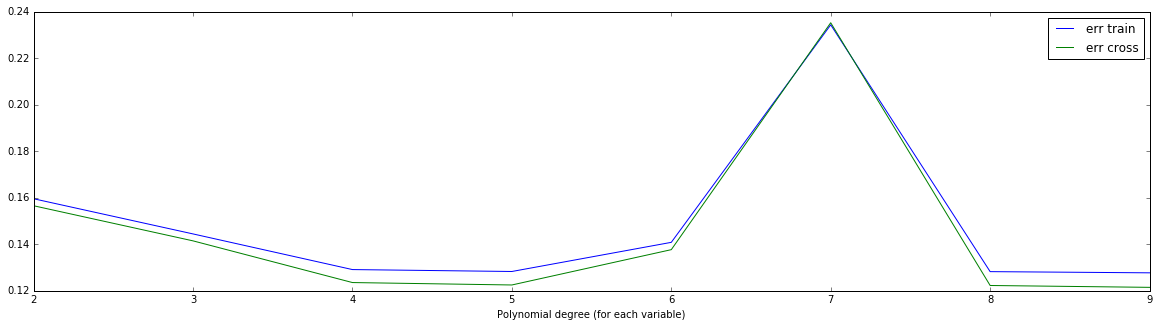

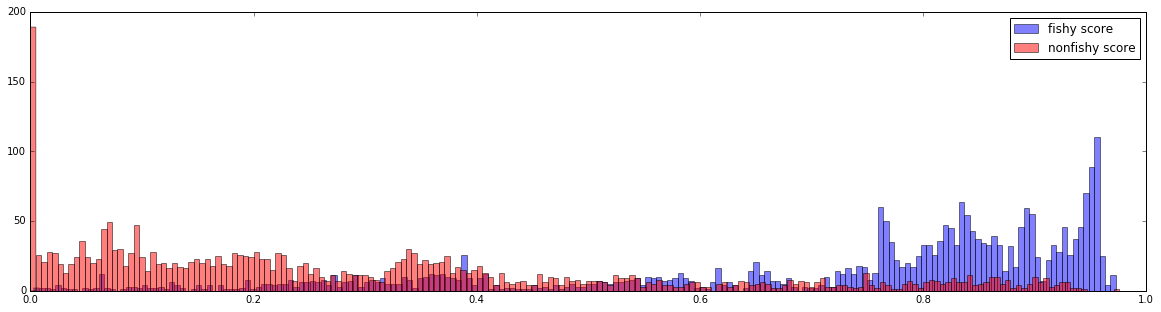

Squared numerical error: 0.13935393631
Error (overlap): 34.96%
False positives given cutoff at 0.5: 33.4780892223%


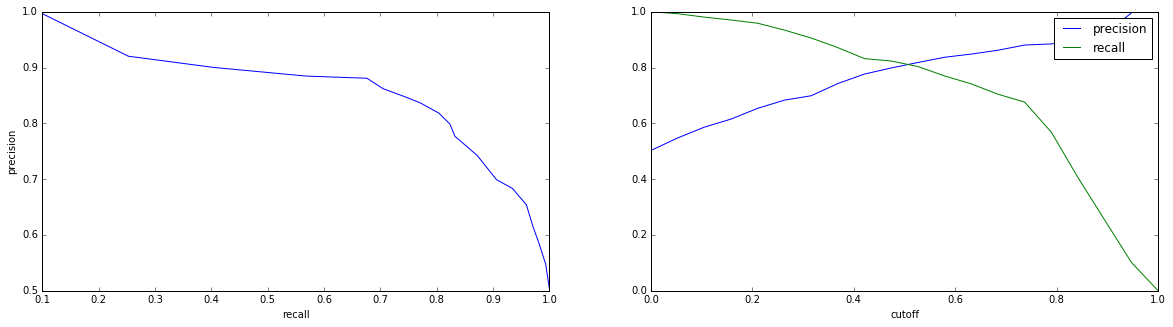

Score window: 86400
Score polynomial: [ 1.2896454  -7.5622936   0.93160224  4.59204337  2.10754254 -4.0696389
  1.2896454   6.28034451 -2.15712376  0.25820366  4.06778358  1.55226692
  1.2896454  -8.101678    3.13468651  4.87916815 -1.96987394 -1.34448285]


In [4]:
xtrain, xcross, xtest = load_dataset('datasets/kristina_ps.measures.npz')
min_window = optimize_window_size(xtrain, xcross)
optimize_polynomial_degree(xtrain, xcross, min_window)
evaluate_score(xtrain, xtest, 6, min_window)